In [150]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx import mesh
from dolfinx.plot import vtk_mesh

from mpi4py import MPI
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad, Mesh, triangle

import numpy as np
import matplotlib.pyplot as plt

import pyvista, pygmsh, gmsh, meshio

In [151]:
# Circle parameters
x0, y0 = 1.2, 0.0  # Center of the circle
r = 1.0  # Radius of the circle
h = 1/256  # Mesh size
element_order = 1

with pygmsh.geo.Geometry() as geom:
    # Create the circle
    circle = geom.add_circle([x0, y0, 0], r, mesh_size=h)
    
    # Generate the mesh
    mesh_io = geom.generate_mesh(order=element_order)
    
    # Extract points and cells (triangles) from the meshio.Mesh object
    points = mesh_io.points[:, :2]  # Only take the 2D coordinates
    cells = np.vstack([cell.data for cell in mesh_io.cells if "triangle" in cell.type])

    # Create the FEniCSx mesh (points as geometry, cells as topology)
    topology = cells.astype(np.int32)
    geometry = points
    
    ufl_domain = Mesh(triangle)
    domain = mesh.create_mesh(MPI.COMM_WORLD, topology, geometry, ufl_domain)

In [152]:
V = functionspace(domain, ("Lagrange", element_order))
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx

In [153]:
def u_exact(x):
    return x[0] / (x[0]**2 + x[1]**2)

def boundary_D(x):
    # Only consider the x and y coordinates (ignore the z-coordinate)
    xy = x[:2]  # Take the first two rows (x and y components)
    return np.isclose(np.linalg.norm(xy - np.array([[x0], [y0]]), axis=0), r)

# Apply the Dirichlet boundary condition
dofs_D = locate_dofs_geometrical(V, boundary_D)
u_bc = Function(V)
u_bc.interpolate(u_exact)
bc = dirichletbc(u_bc, dofs_D)

In [154]:
f = Constant(domain, default_scalar_type(0))
L = f * v * dx

In [155]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "cholesky"})
uh = problem.solve()

V2 = functionspace(domain, ("Lagrange", 8))
uex = Function(V2)
uex.interpolate(u_exact)
error_L2 = assemble_scalar(form((uh - uex)**2 * dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Error_L2 : {error_L2:.6e}")
print(f"Error_max : {error_max:.6e}")

Error_L2 : 1.787380e-05
Error_max : 1.169776e-04


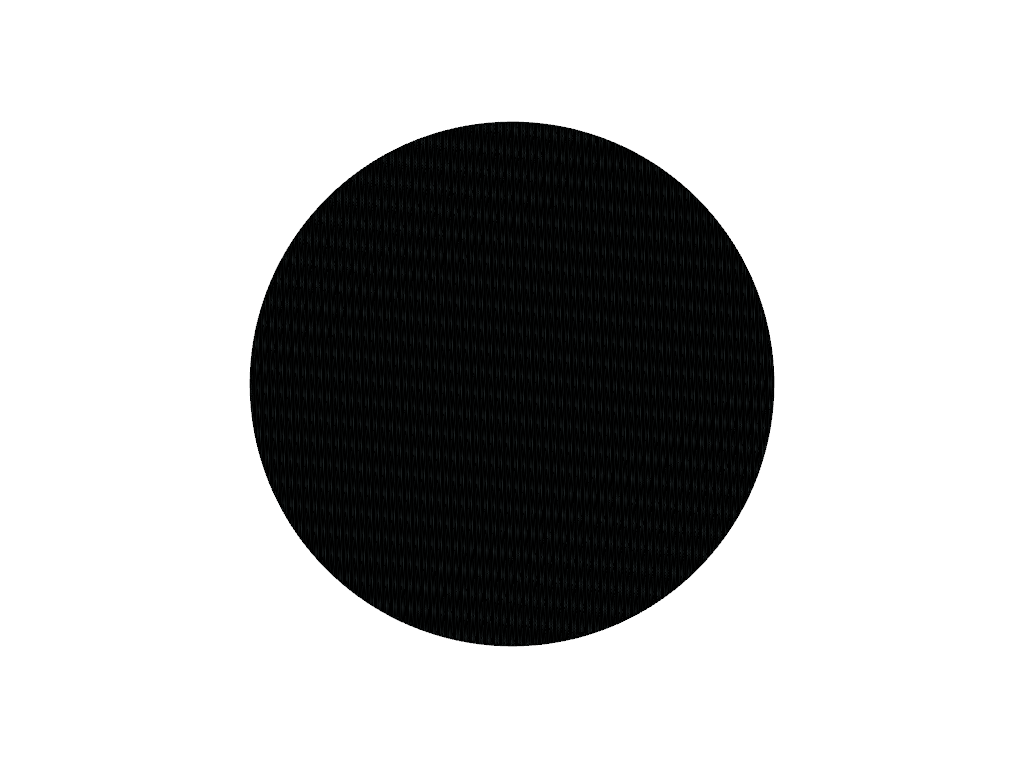

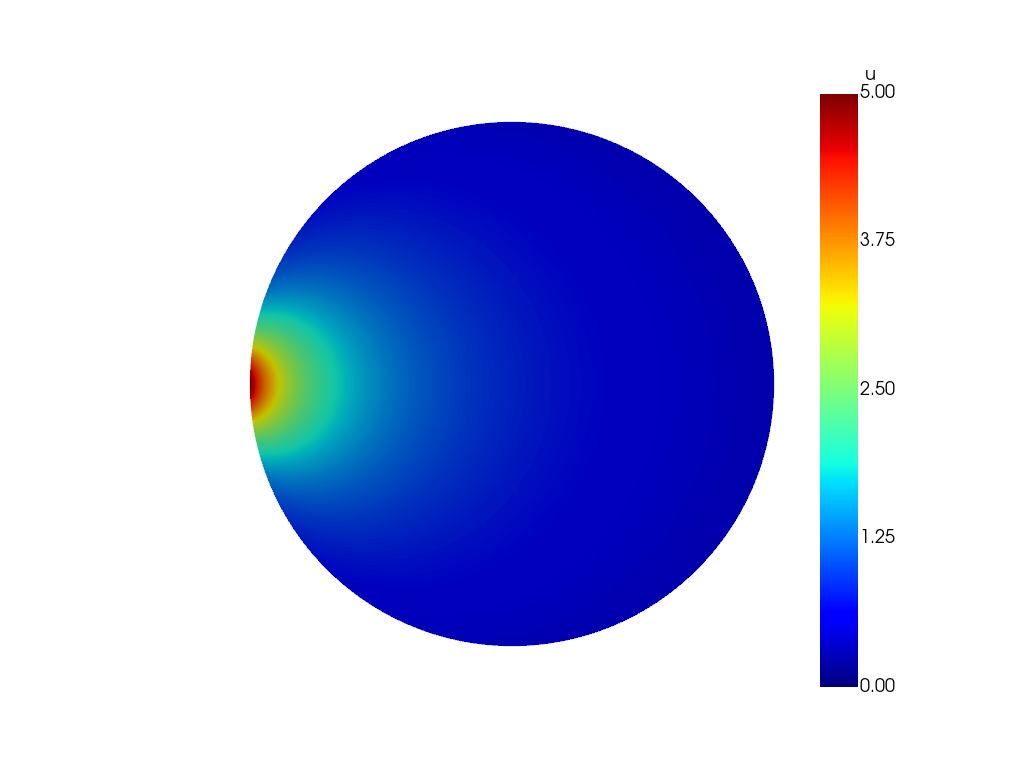

In [156]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

u_topology, u_cell_types, u_geometry = vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()

scalar_bar_args = {"title": "u", "vertical": True, "position_x": 0.8, "position_y": 0.1, "width": 0.1, "height": 0.8}
u_plotter.add_mesh(u_grid, show_edges=False, cmap="jet", clim=[0, 5], scalar_bar_args=scalar_bar_args)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

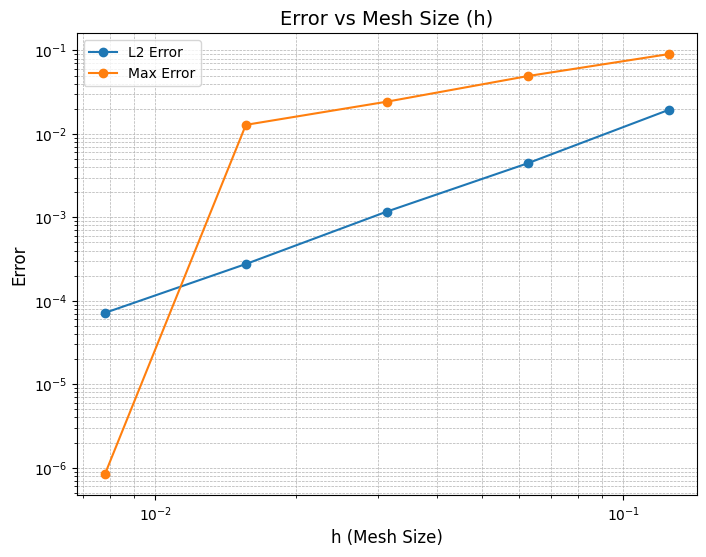

In [157]:
def plot_errors(h, e, l):
    """
    Plots the error vs mesh size on a log-log plot.

    Args:
    h : array-like
        Vector of mesh sizes.
    e : 2D array-like
        Matrix where each row corresponds to the errors for a specific label.
    l : array-like
        List of labels for each row in the error matrix.
    """
    
    # Create a log-log plot
    plt.figure(figsize=(8, 6))
    
    # Plot each row of errors with the corresponding label
    for i, label in enumerate(l):
        plt.loglog(h, e[i, :], label=label, marker='o')
    
    # Add labels and title
    plt.xlabel('h (Mesh Size)', fontsize=12)
    plt.ylabel('Error', fontsize=12)
    plt.title('Error vs Mesh Size (h)', fontsize=14)
    
    # Add a legend
    plt.legend()
    
    # Enable grid
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Show the plot
    plt.show()

h = np.array([1/8, 1/16, 1/32, 1/64, 1/128])
e = np.array([
    [1.937466e-02, 4.444241e-03, 1.171624e-03, 2.760342e-04, 7.172011e-05],
    [9.031447e-02, 4.927410e-02, 2.430762e-02, 1.283247e-02, 8.387160e-07]])
l = ['L2 Error', 'Max Error']

plot_errors(h, e, l)